In [13]:
import torch
from torchvision import transforms

from torchinfo import summary

import matplotlib.pyplot as plt

from tqdm import tqdm

import ParabolaGen
import NoiseGen

In [14]:
x_dim = 92
y_dim = 120
time_dimension = 1000
num_of_files = 1
origin = None    #Set to none to have random origins, or input coordinates (x,y, ToF)

train_data = ParabolaGen.generate_parabola(x_dim, y_dim, time_dimension, 128, origin).unsqueeze(1)
test_data = ParabolaGen.generate_parabola(x_dim, y_dim, time_dimension, 32, origin).unsqueeze(1)

train_data_noisy = torch.clamp((NoiseGen.generate_gaussian_noise(128, 120, 92, mean=0, std=0.1) + NoiseGen.generate_binary_noise(128, 120, 92, magnitude=1, p=0.3)).unsqueeze(1) + train_data, 0, 1)
test_data_noisy = torch.clamp((NoiseGen.generate_gaussian_noise(32, 120, 92, mean=0, std=0.1) + NoiseGen.generate_binary_noise(32, 120, 92, magnitude=1, p=0.3)).unsqueeze(1) + test_data, 0, 1)

In [15]:
device = "cuda" if torch.cuda.is_available() else "mps"

In [16]:
train_data.shape

torch.Size([128, 1, 120, 92])

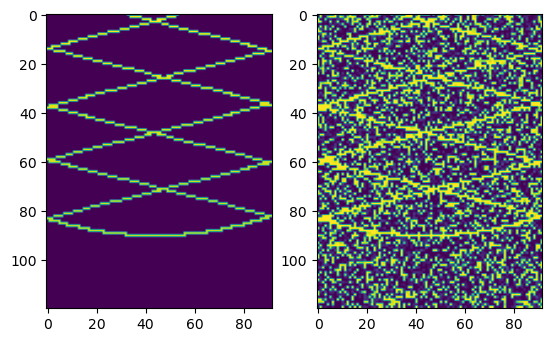

In [17]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(train_data[0][0])
ax[1].imshow(train_data_noisy[0][0])

In [18]:
class ConvolutionAutoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, 3, stride=1),  # Output: (16, 60, 45)
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 16, 3, stride=1), # Output: (32, 30, 23)
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 8, 3, stride=1), # Output: (64, 15, 12)
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(),
            # torch.nn.Flatten(1),
            # torch.nn.Linear(64*114*84, 128),
            # torch.nn.ReLU(),
        )
        
        self.decoder = torch.nn.Sequential(
            # torch.nn.Linear(128, 64*114*84),
            # torch.nn.ReLU(),
            # torch.nn.Unflatten(1, (64, 114, 84)),
            torch.nn.ConvTranspose2d(8, 16, 3, stride=1), # Output: (32, 30, 23)
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 64, 3, stride=1), # Output: (16, 60, 45)
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 1, 3, stride=1), # Output: (1, 120, 90)
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [19]:
class Embedding(torch.nn.Module):
    def __init__(self, patch_size:int=4, embedding_size:int=16, embedding_dropout:float=0.1):
        super().__init__()

        self.patch_size = patch_size
        self.embedding_size = embedding_size

        self.embedding = torch.nn.Sequential(
            torch.nn.Conv2d(1, embedding_size, patch_size, patch_size, 0),
            torch.nn.Flatten(2, 3)
        )
    
    def forward(self, x):
        # Embedding shape (BatchSize, Co)
        patch_embeddings = self.embedding(x).permute(0, 2, 1)
        batch_size = patch_embeddings.shape[0]

        positional_embeddings = torch.nn.Parameter(torch.zeros(batch_size, patch_embeddings.shape[1], self.embedding_size)).to(x.device)
        embeddings = patch_embeddings + positional_embeddings

        return embeddings

In [20]:
class Transformer(torch.nn.Module):
    def __init__(self, embedding_size=16):
        super().__init__()

        self.embedding = Embedding(embedding_size=embedding_size)

        self.encoder = torch.nn.TransformerEncoderLayer(
            d_model=embedding_size, 
            nhead=2, 
            batch_first=True, 
            norm_first=True
        )
        self.decoder = torch.nn.TransformerDecoderLayer(
            d_model=embedding_size, 
            nhead=2, 
            batch_first=True, 
            norm_first=True
        )

    def forward(self, x):
        x = self.embedding(x)
        x = self.encoder(x)
        x = self.decoder(x, x)
        return x


In [21]:
autoencoder = Transformer().to(device)
loss_function = torch.nn.MSELoss()
optimiser = torch.optim.Adam(autoencoder.parameters(), lr=0.01)

In [22]:
for epoch in tqdm(range(100)):
    optimiser.zero_grad()
    outputs = autoencoder(train_data_noisy.view(-1, 120*92).to(device))
    loss = loss_function(outputs, train_data.view(-1, 120*92).to(device))
    loss.backward()
    optimiser.step()

100%|██████████| 100/100 [00:00<00:00, 224.59it/s]


In [23]:
torch.cuda.empty_cache()

In [25]:
autoencoder.eval()

with torch.no_grad():
    pred = autoencoder.to("cpu")(test_data_noisy[0].view(-1, 120*92).to("cpu"))

In [28]:
pred[0].shape

torch.Size([11040])

Text(0.5, 1.0, 'Reconstructed Image')

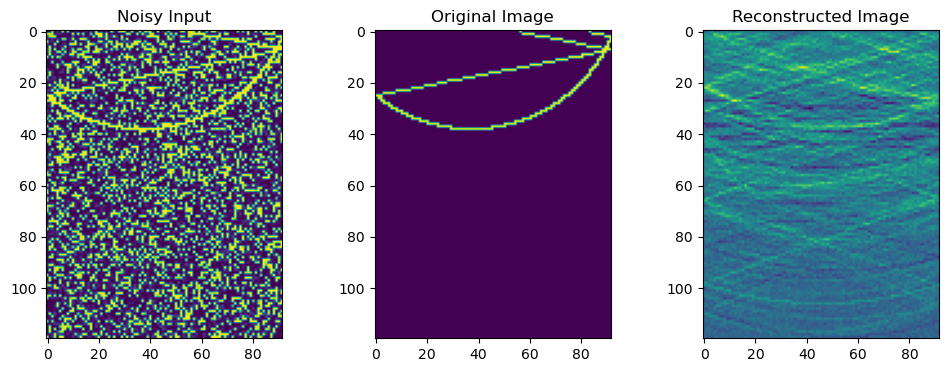

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(test_data_noisy[0][0].to("cpu"))
ax[1].imshow(test_data[0][0].to("cpu"))
ax[2].imshow(pred[0].reshape(120, 92))

ax[0].set_title("Noisy Input")
ax[1].set_title("Original Image")
ax[2].set_title("Reconstructed Image")